In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_confirmed=pd.read_csv('/content/drive/My Drive/global_covid_confirmed_daily_updates.csv')
data_deaths=pd.read_csv('/content/drive/My Drive/global_covid_deaths_daily_updates.csv')

In [3]:
data_confirmed.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36


In [4]:
data_deaths.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36,36,40,42,43,47,50,57,58,60,64,68,72,85,90,95,104,106
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26,26,27,27,27,27,28,28,30,30,31,31,31,31,31,31,31,31
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384,392,402,407,415,419,425,432,437,444,450,453,459,463,465,470,476,483
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37,37,37,37,40,40,40,40,41,42,42,43,44,45,45,46,46,47
4,Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [0]:
def get_values(data,country):
  value=[]
  new=data.loc[data['Country/Region']==country,'1/22/20':'5/7/20']
  k=data[data['Country/Region']==country].index.to_list()
  columns=new.columns
  for i in columns:
    value.append(new[i][k[0]])
  return value  

In [0]:
values=get_values(data_confirmed,country='Benin')

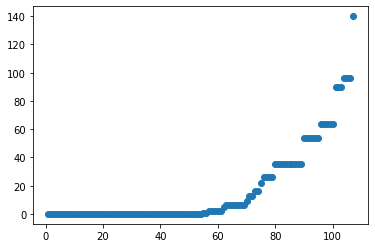

In [7]:
plt.scatter(range(1,108),values)

In [0]:
def basic_model(data):
  result=[]
  a=list(data['Country/Region'])
  for i in a:
    new=data.loc[data['Country/Region']==i,'5/4/20':'5/6/20']
    k=data[data['Country/Region']==i].index.to_list()
    a1=new['5/4/20'][k[0]]
    a2=new['5/5/20'][k[0]]
    a3=new['5/6/20'][k[0]]
    dif1=a2-a1
    dif2=a3-a2
    dif=(dif1+dif2)/2
    result.append(a3+dif)
  return result    

In [0]:
confirmed=basic_model(data_confirmed)

In [10]:
print(len(confirmed))

187


In [0]:
deaths=basic_model(data_deaths)

In [0]:
final=pd.DataFrame({'Country/Region':data_confirmed['Country/Region'],'Confirmed':confirmed,'Death':deaths})
final.head()

,Country/Region,Confirmed,Death
0,Afghanistan,3641.0,111.0
1,Albania,846.5,31.0
2,Algeria,5171.5,481.5
3,Andorra,751.5,46.5
4,Angola,36.5,2.0


In [0]:
final['Confirmed']=final['Confirmed'].astype('int')

In [0]:
final['Death']=final['Death'].astype('int')

In [0]:
final.to_excel('final_covid_19.xlsx')

In [0]:
print(final.loc[final['Country/Region']=='India'])

   Country/Region  Confirmed   Death
78          India    56262.0  1894.5


In [69]:
#rmse for basic model
from sklearn.metrics import mean_squared_error
print('rmse for confirmed cases=',mean_squared_error(data_confirmed['5/7/20'][:20],confirmed[:20]))
print('rmse for deaths=',mean_squared_error(data_deaths['5/7/20'][:20],deaths[:20]))


rmse for confirmed cases= 26200.16763570569
rmse for deaths= 58.36920705906357


# **Model Creation**

In [0]:
def remove_zeroes(array):
  for i in array:
    if i==0:
      array.remove(i)
  new_array=array    
  return new_array   

In [0]:
def give_difference(data,country):
  intermediate=[]
  values=get_values(data,country)
  new=remove_zeroes(values)
  for j in range(1,len(new)):
    intermediate.append(new[j]-new[j-1]) 
  return intermediate

In [0]:
differences=give_difference(data=data_confirmed,country='Afghanistan')

In [28]:
differences=np.array(differences)
print(differences.shape)

(89,)


In [0]:
from keras import layers
from keras import models
def data_preparation_fitting_lstm(data):
  f=np.random.randint(1,100,2)
  a=list(data['Country/Region'])[:20]
  actual,predicted=[],[]
  for i in a:
    differences=give_difference(data,i)
    differences=np.array(differences)
    size=differences.shape[0]
    b=differences[:-3]
    x_train=[]
    y_train=[]
    x_test=differences[-3:-1]
    y_test=differences[-1]
    for j in range(2,b.shape[0]):
      x_train.append(b[j-2:j])
      y_train.append(b[j])
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    x_train=x_train.reshape(x_train.shape[0],2,1)
    x_test=np.row_stack((x_test,f))
    x_test=x_test.reshape(2,2,1)            
    model=models.Sequential()
    model.add(layers.LSTM(10,activation='relu',input_shape=(2,1)))
    model.add(layers.Dense(1))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.fit(x_train,y_train,epochs=100)
    predict=model.predict(x_test)
    actual.append(y_test)
    predicted.append(predict[0])
  result=pd.DataFrame({'actual':actual,'predicted':predicted})
  error=mean_squared_error(actual,predicted)
  return result,error


In [71]:
result_lstm1,error_lstm1=data_preparation_fitting_lstm(data=data_confirmed)

Epoch 1/100
84/84 [==============================] - 0s 4ms/step - loss: 6904.0961 - accuracy: 0.3571
Epoch 2/100
84/84 [==============================] - 0s 134us/step - loss: 6670.7357 - accuracy: 0.3571
Epoch 3/100
84/84 [==============================] - 0s 107us/step - loss: 6507.7236 - accuracy: 0.3690
Epoch 4/100
84/84 [==============================] - 0s 131us/step - loss: 6283.6701 - accuracy: 0.3690
Epoch 5/100
84/84 [==============================] - 0s 128us/step - loss: 6070.3411 - accuracy: 0.3690
Epoch 6/100
84/84 [==============================] - 0s 129us/step - loss: 5850.3276 - accuracy: 0.3690
Epoch 7/100
84/84 [==============================] - 0s 129us/step - loss: 5582.2418 - accuracy: 0.3690
Epoch 8/100
84/84 [==============================] - 0s 126us/step - loss: 5305.5440 - accuracy: 0.3690
Epoch 9/100
84/84 [==============================] - 0s 128us/step - loss: 5047.2851 - accuracy: 0.3690
Epoch 10/100
84/84 [==============================] - 0s 134us/ste

In [74]:
result_lstm2,error_lstm2=data_preparation_fitting_lstm(data_deaths)

Epoch 1/100
71/71 [==============================] - 0s 5ms/step - loss: 5.6317 - accuracy: 0.6197
Epoch 2/100
71/71 [==============================] - 0s 176us/step - loss: 5.5973 - accuracy: 0.6197
Epoch 3/100
71/71 [==============================] - 0s 147us/step - loss: 5.5664 - accuracy: 0.6197
Epoch 4/100
71/71 [==============================] - 0s 162us/step - loss: 5.5264 - accuracy: 0.6197
Epoch 5/100
71/71 [==============================] - 0s 155us/step - loss: 5.4931 - accuracy: 0.6056
Epoch 6/100
71/71 [==============================] - 0s 133us/step - loss: 5.4583 - accuracy: 0.6056
Epoch 7/100
71/71 [==============================] - 0s 141us/step - loss: 5.4181 - accuracy: 0.6056
Epoch 8/100
71/71 [==============================] - 0s 127us/step - loss: 5.3859 - accuracy: 0.6056
Epoch 9/100
71/71 [==============================] - 0s 102us/step - loss: 5.3447 - accuracy: 0.5915
Epoch 10/100
71/71 [==============================] - 0s 108us/step - loss: 5.3047 - accuracy

In [73]:
print(result_lstm1)

    actual     predicted
0      171   [379.68457]
1       10   [15.419701]
2      185    [172.5413]
3        1   [0.8171359]
4        0  [0.37623823]
5        0  [0.31342903]
6      163   [147.68913]
7      102   [135.82007]
8       19   [29.260014]
9       68  [0.29395053]
10      77    [70.64806]
11       0   [2.3210459]
12     265   [128.59747]
13     706    [816.9468]
14       0  [0.55280554]
15     913    [893.2212]
16     639   [236.23898]
17       0  [0.20349348]
18      44   [0.5192162]
19       0  [0.09130466]


In [72]:
confirmed=data_confirmed['5/6/20']+result_lstm1['predicted']
deaths=data_deaths['5/6/20']+result_lstm2['predicted']
print('rmse for confirmed cases=',mean_squared_error(data_confirmed['5/7/20'][:20],confirmed))
print('rmse for deaths=',mean_squared_error(data_deaths['5/7/20'][:20],deaths))

NameError: ignored

In [0]:
import xgboost as xgb
def data_preparation_fitting_XGBoost(data):
  f=np.random.randint(1,100,2)
  a=list(data['Country/Region'])
  actual,predicted=[],[]
  for i in a:
    differences=give_difference(data,i)
    differences=np.array(differences)
    size=differences.shape[0]
    b=differences[:-3]
    x_train=[]
    y_train=[]
    x_test=differences[-3:-1]
    y_test=differences[-1]
    for j in range(2,b.shape[0]):
      x_train.append(b[j-2:j])
      y_train.append(b[j])
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    #x_train=x_train.reshape(x_train.shape[0],2,1)
    x_test=np.row_stack((x_test,f))
    #x_test=x_test.reshape(2,2,1)            
    from sklearn.metrics import mean_squared_error
    m1=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
    m1.fit(x_train,y_train)
    predict=m1.predict(x_test)
    actual.append(y_test)
    predicted.append(predict[0])
  result=pd.DataFrame({'actual':actual,'predicted':predicted})
  error=mean_squared_error(actual,predicted)
  return result,error


In [0]:
result1,error1=data_preparation_fitting_XGBoost(data_deaths)

In [0]:
result2,error2=data_preparation_fitting_XGBoost(data_confirmed)

In [64]:
print(result2)

     actual  predicted
0       171  91.399399
1        10  11.244570
2       185  87.183891
3         1   0.611215
4         0   0.306605
..      ...        ...
182       1   2.957816
183       0   0.237841
184       0   0.683852
185       7   0.591655
186       0   0.512367

[187 rows x 2 columns]


In [68]:
#getting the rmse
confirmed=data_confirmed['5/6/20']+result2['predicted']
deaths=data_deaths['5/6/20']+result1['predicted']
print('rmse for confirmed cases=',mean_squared_error(data_confirmed['5/7/20'],confirmed))
print('rmse for deaths=',mean_squared_error(data_deaths['5/7/20'],deaths))

rmse for confirmed cases= 1110596.0359581052
rmse for deaths= 6399.287133307835
